In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [5]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [6]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [7]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [8]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


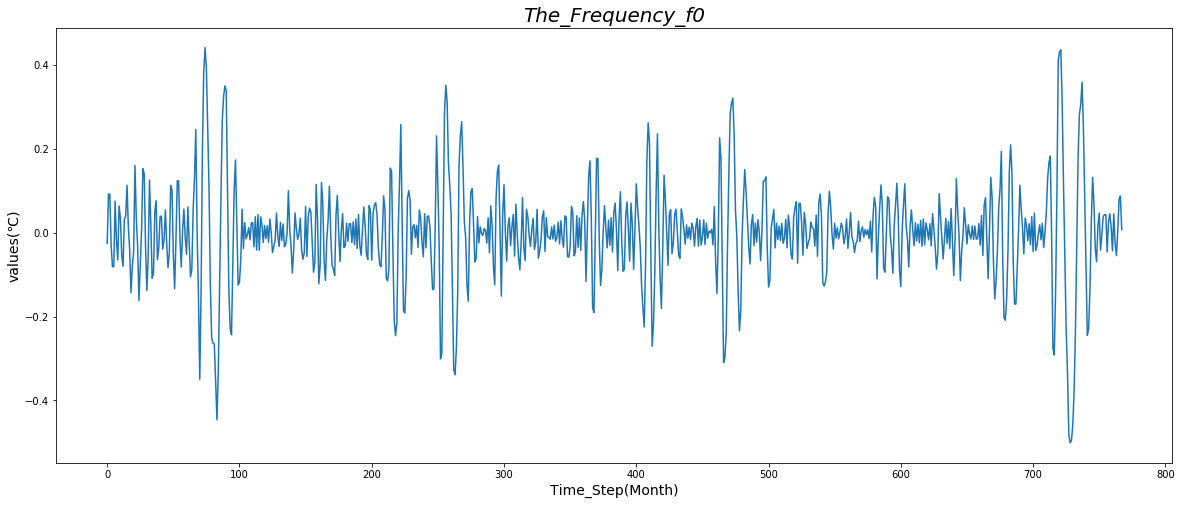

(720, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 6s - loss: 0.0141
Epoch 2/200
 - 3s - loss: 0.0140
Epoch 3/200
 - 3s - loss: 0.0140
Epoch 4/200
 - 3s - loss: 0.0140
Epoch 5/200
 - 3s - loss: 0.0138
Epoch 6/200
 - 3s - loss: 0.0137
Epoch 7/200
 - 3s - loss: 0.0133
Epoch 8/200
 - 3s - loss: 0.0133
Epoch 9/200
 - 3s - loss: 0.0127
Epoch 10/200
 - 3s - loss: 0.0120
Epoch 11/200
 - 3s - loss: 0.0124
Epoch 12/200
 - 3s - loss: 0.0121
Epoch 13/200
 - 3s - loss: 0.0120
Epoch 14/200
 - 3s - loss: 0.0118
Epoch 15/200
 - 3s - loss: 0.0115
Epoch 16/200
 - 3s - loss: 0.0112
Epoch 17/200
 - 3s - loss: 0.0113
Epoch 18/200
 - 3s - loss: 0.0111
Epoch 19/200
 - 3s - loss: 0.0110
Epoch 20/200
 - 3s - loss: 0.0110
Epoch 21/200
 - 3s - loss: 0.0109
Epoch 22/200
 - 5s - loss: 0.0107
Epoch 23/200


(61, 12)


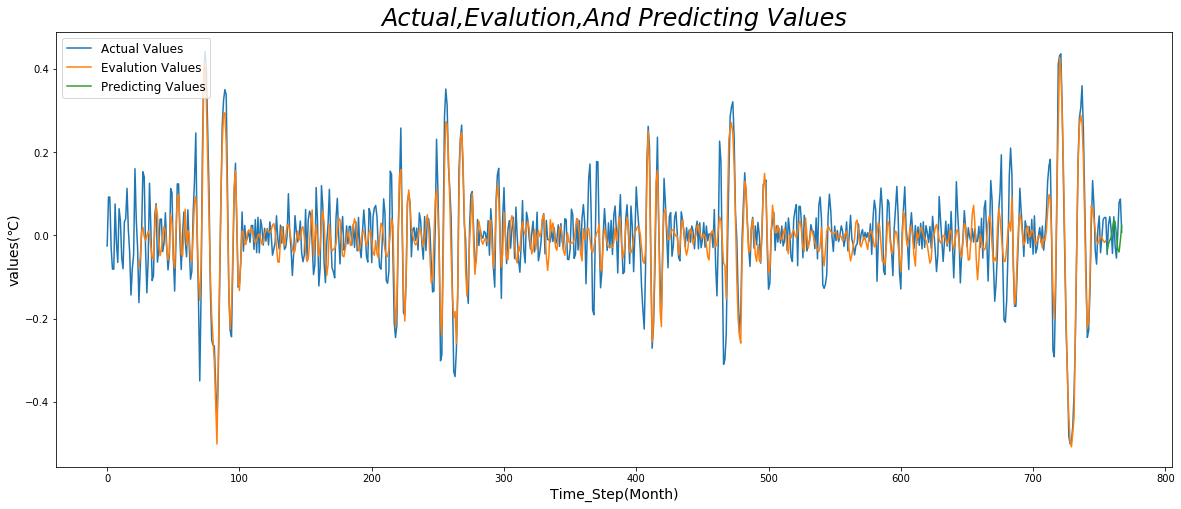

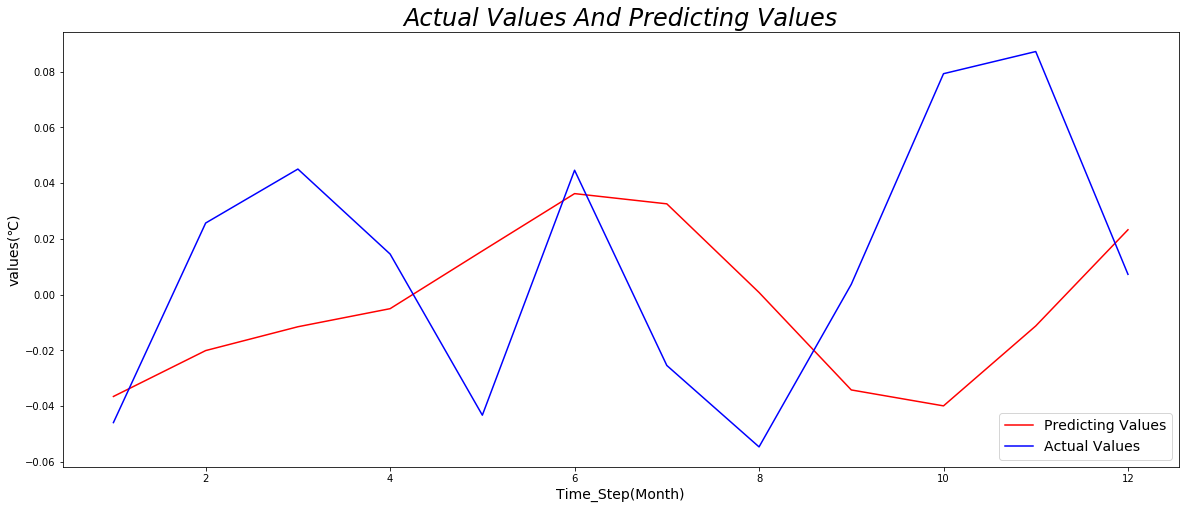

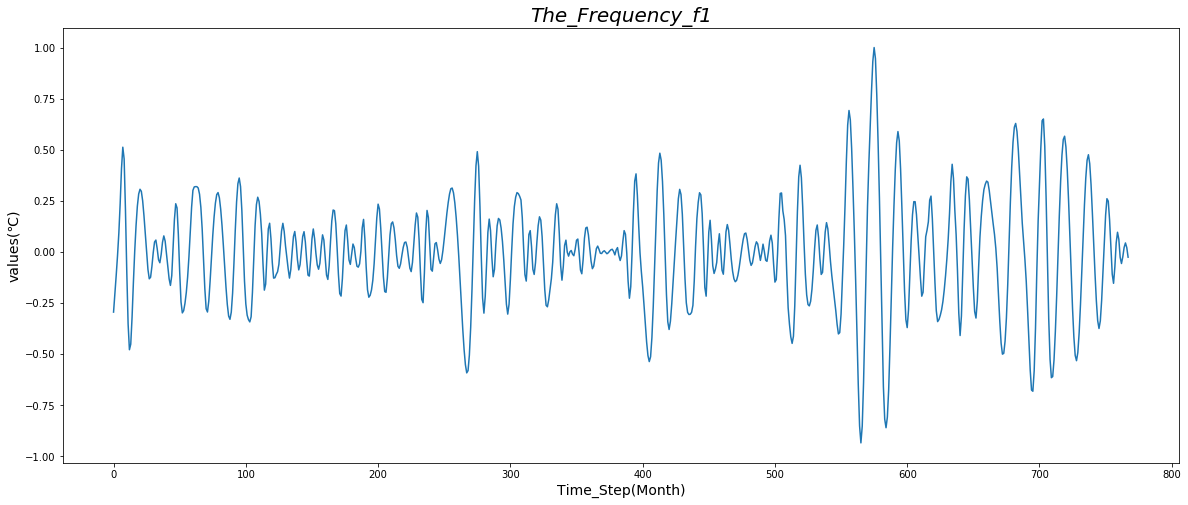

(720, 24, 1)
Epoch 1/200
 - 8s - loss: 0.0653
Epoch 2/200
 - 4s - loss: 0.0563
Epoch 3/200
 - 4s - loss: 0.0471
Epoch 4/200
 - 4s - loss: 0.0482
Epoch 5/200
 - 4s - loss: 0.0435
Epoch 6/200
 - 3s - loss: 0.0425
Epoch 7/200
 - 3s - loss: 0.0394
Epoch 8/200
 - 3s - loss: 0.0382
Epoch 9/200
 - 3s - loss: 0.0400
Epoch 10/200
 - 3s - loss: 0.0377
Epoch 11/200
 - 3s - loss: 0.0378
Epoch 12/200
 - 3s - loss: 0.0372
Epoch 13/200
 - 3s - loss: 0.0338
Epoch 14/200
 - 3s - loss: 0.0321
Epoch 15/200
 - 3s - loss: 0.0322
Epoch 16/200
 - 3s - loss: 0.0332
Epoch 17/200
 - 3s - loss: 0.0309
Epoch 18/200
 - 3s - loss: 0.0327
Epoch 19/200
 - 3s - loss: 0.0295
Epoch 20/200
 - 3s - loss: 0.0297
Epoch 21/200
 - 3s - loss: 0.0288
Epoch 22/200
 - 3s - loss: 0.0298
Epoch 23/200
 - 3s - loss: 0.0284
Epoch 24/200
 - 3s - loss: 0.0273
Epoch 25/200
 - 3s - loss: 0.0272
Epoch 26/200
 - 3s - loss: 0.0262
Epoch 27/200
 - 3s - loss: 0.0265
Epoch 28/200
 - 3s - loss: 0.0258
Epoch 29/200
 - 3s - loss: 0.0260
Epoch 30/2

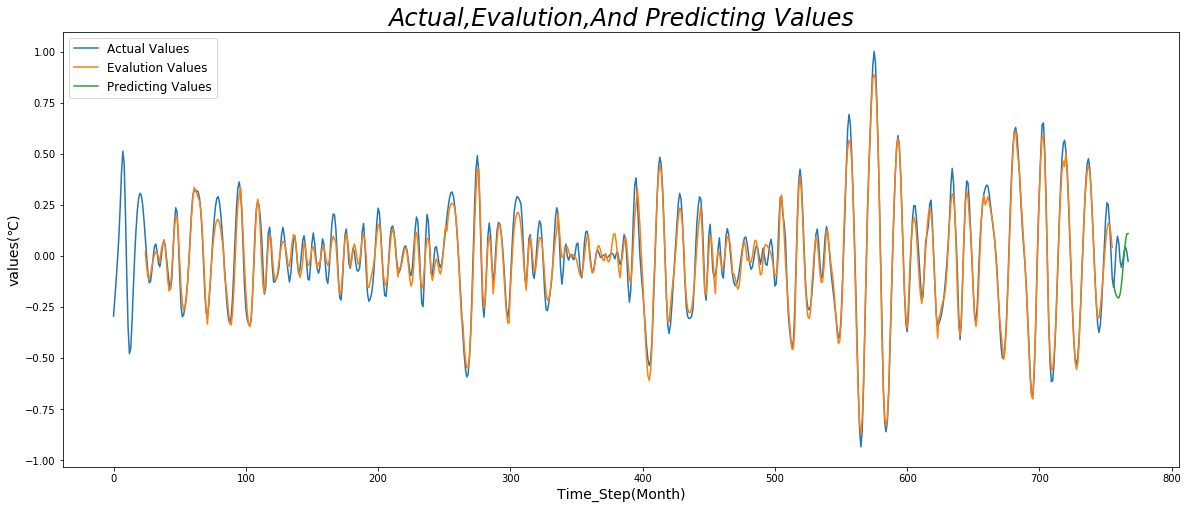

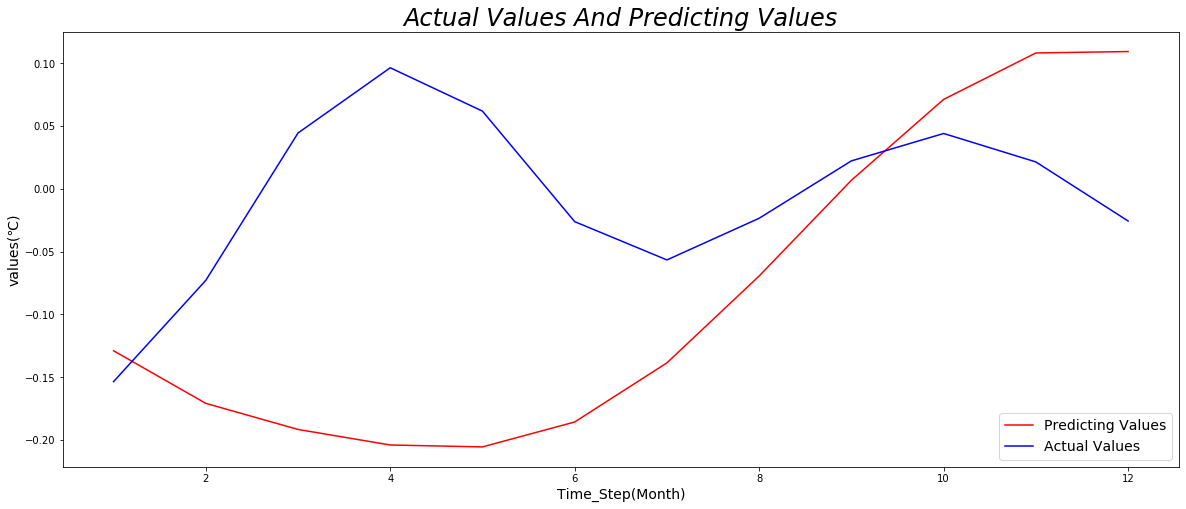

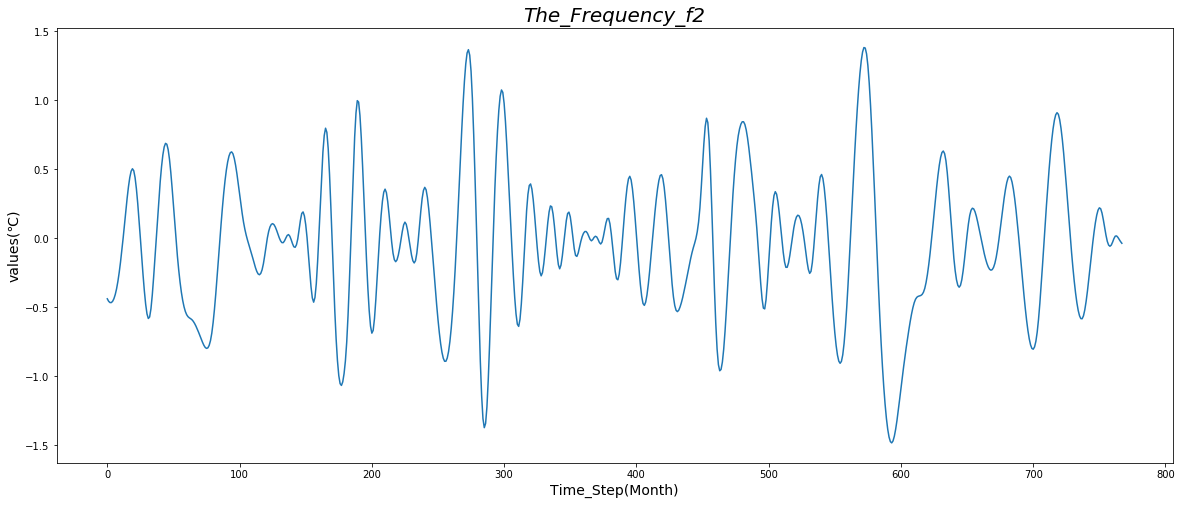

(720, 24, 1)
Epoch 1/200
 - 8s - loss: 0.2516
Epoch 2/200
 - 5s - loss: 0.2420
Epoch 3/200
 - 4s - loss: 0.2243
Epoch 4/200
 - 4s - loss: 0.1906
Epoch 5/200
 - 4s - loss: 0.1439
Epoch 6/200
 - 4s - loss: 0.1365
Epoch 7/200
 - 4s - loss: 0.1134
Epoch 8/200
 - 4s - loss: 0.1054
Epoch 9/200
 - 4s - loss: 0.0940
Epoch 10/200
 - 4s - loss: 0.0861
Epoch 11/200
 - 4s - loss: 0.0846
Epoch 12/200
 - 4s - loss: 0.0769
Epoch 13/200
 - 4s - loss: 0.0827
Epoch 14/200
 - 4s - loss: 0.0712
Epoch 15/200
 - 4s - loss: 0.0742
Epoch 16/200
 - 4s - loss: 0.0645
Epoch 17/200
 - 4s - loss: 0.0646
Epoch 18/200
 - 4s - loss: 0.0753
Epoch 19/200
 - 4s - loss: 0.0623
Epoch 20/200
 - 4s - loss: 0.0649
Epoch 21/200
 - 4s - loss: 0.0645
Epoch 22/200
 - 4s - loss: 0.0625
Epoch 23/200
 - 4s - loss: 0.0570
Epoch 24/200
 - 4s - loss: 0.0537
Epoch 25/200
 - 4s - loss: 0.0514
Epoch 26/200
 - 4s - loss: 0.0520
Epoch 27/200
 - 4s - loss: 0.0520
Epoch 28/200
 - 4s - loss: 0.0530
Epoch 29/200
 - 4s - loss: 0.0527
Epoch 30/2

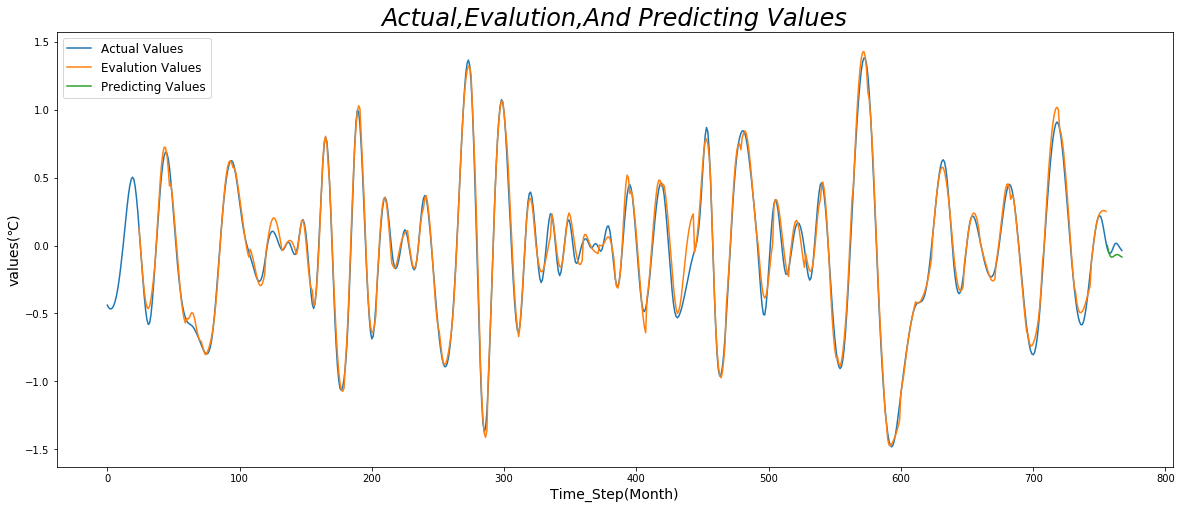

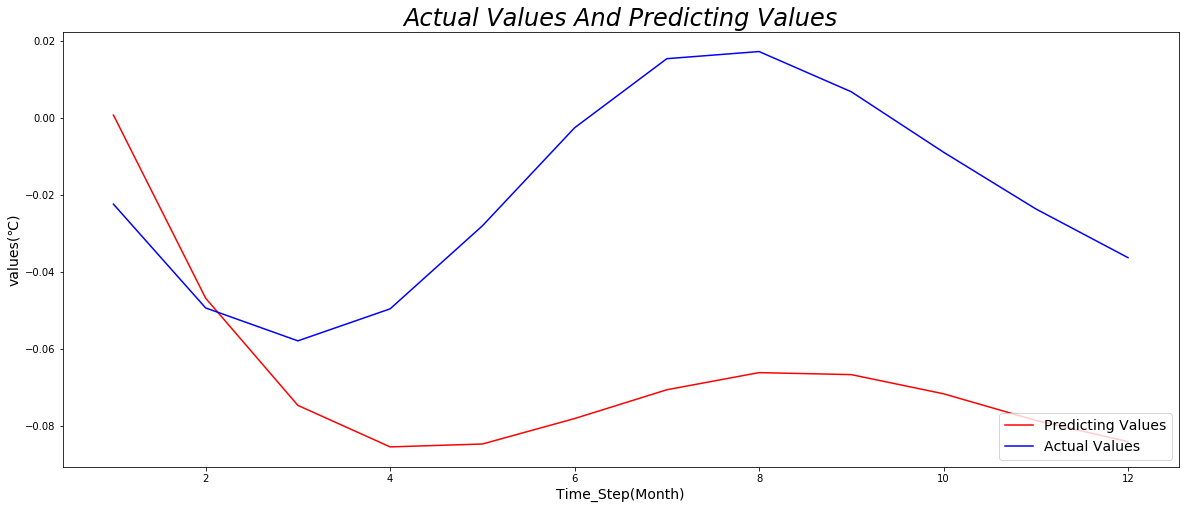

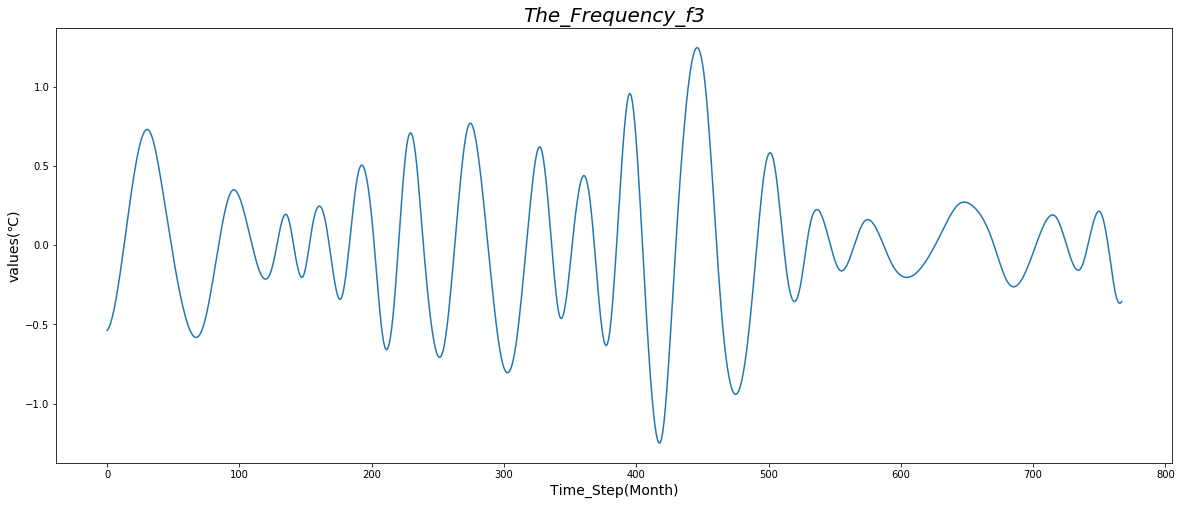

(720, 24, 1)
Epoch 1/200
 - 11s - loss: 0.1542
Epoch 2/200
 - 6s - loss: 0.1191
Epoch 3/200
 - 5s - loss: 0.0950
Epoch 4/200
 - 5s - loss: 0.0638
Epoch 5/200
 - 5s - loss: 0.0605
Epoch 6/200
 - 5s - loss: 0.0457
Epoch 7/200
 - 5s - loss: 0.0342
Epoch 8/200
 - 5s - loss: 0.0339
Epoch 9/200
 - 5s - loss: 0.0323
Epoch 10/200
 - 5s - loss: 0.0269
Epoch 11/200
 - 5s - loss: 0.0218
Epoch 12/200
 - 5s - loss: 0.0189
Epoch 13/200
 - 5s - loss: 0.0195
Epoch 14/200
 - 5s - loss: 0.0167
Epoch 15/200
 - 5s - loss: 0.0192
Epoch 16/200
 - 5s - loss: 0.0198
Epoch 17/200
 - 5s - loss: 0.0173
Epoch 18/200
 - 5s - loss: 0.0170
Epoch 19/200
 - 5s - loss: 0.0149
Epoch 20/200
 - 5s - loss: 0.0162
Epoch 21/200
 - 5s - loss: 0.0125
Epoch 22/200
 - 5s - loss: 0.0148
Epoch 23/200
 - 5s - loss: 0.0126
Epoch 24/200
 - 5s - loss: 0.0138
Epoch 25/200
 - 5s - loss: 0.0152
Epoch 26/200
 - 5s - loss: 0.0165
Epoch 27/200
 - 5s - loss: 0.0145
Epoch 28/200
 - 5s - loss: 0.0190
Epoch 29/200
 - 5s - loss: 0.0199
Epoch 30/

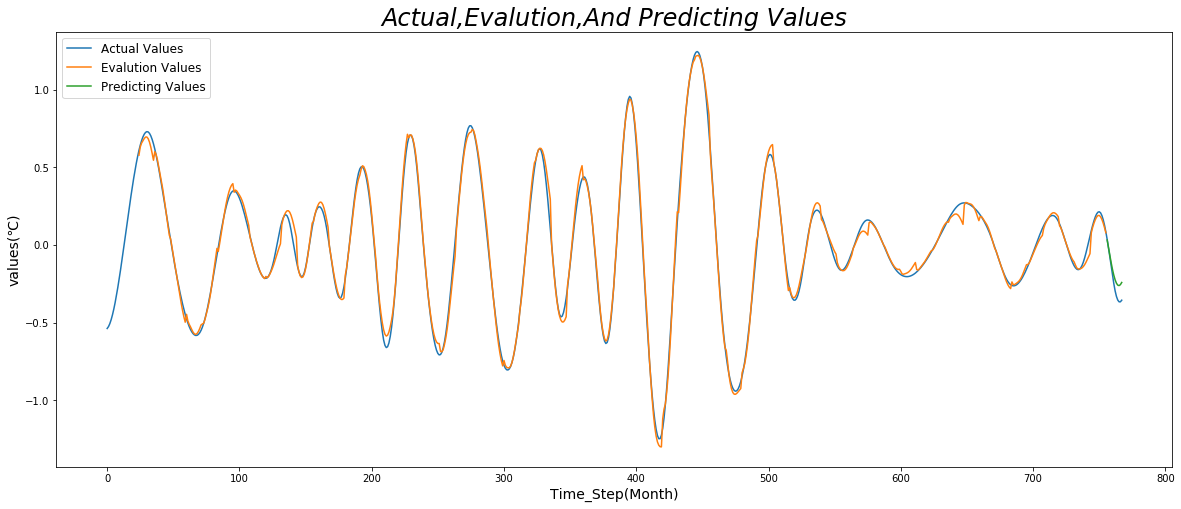

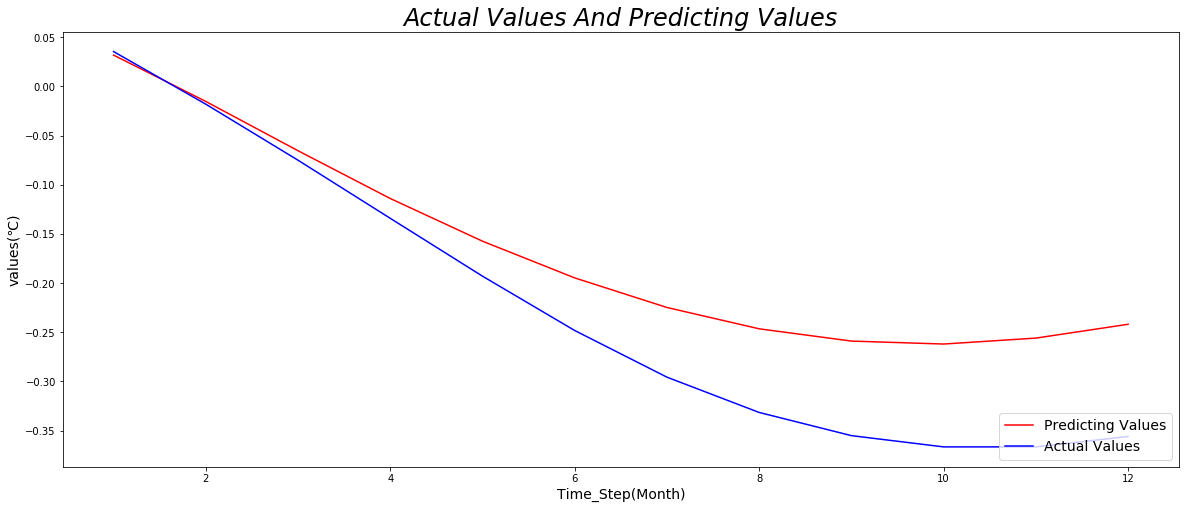

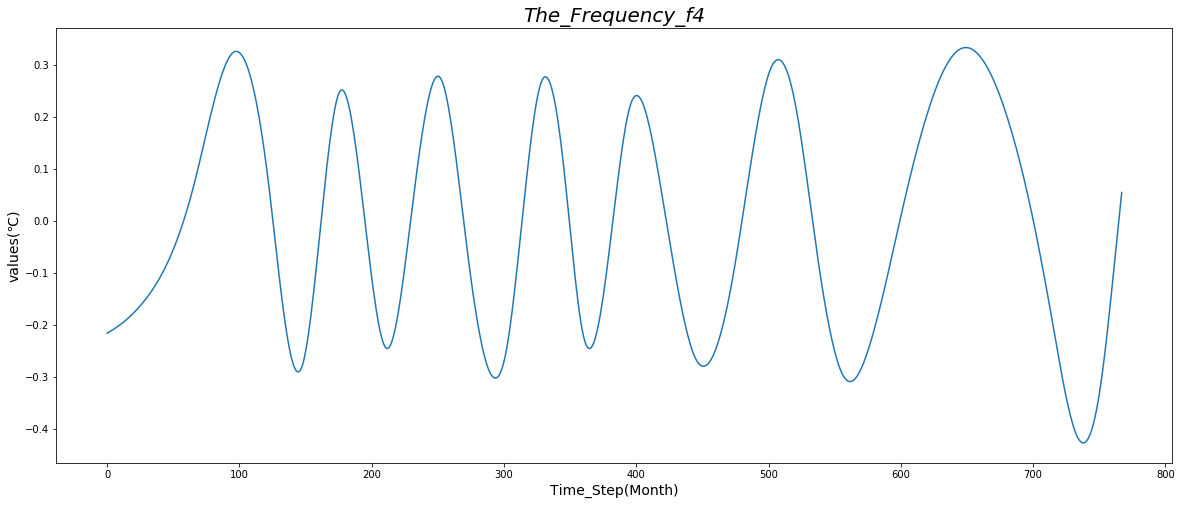

(720, 24, 1)
Epoch 1/200
 - 11s - loss: 0.0291
Epoch 2/200
 - 6s - loss: 0.0097
Epoch 3/200
 - 6s - loss: 0.0066
Epoch 4/200
 - 5s - loss: 0.0046
Epoch 5/200
 - 5s - loss: 0.0036
Epoch 6/200
 - 5s - loss: 0.0037
Epoch 7/200
 - 5s - loss: 0.0027
Epoch 8/200
 - 5s - loss: 0.0023
Epoch 9/200
 - 5s - loss: 0.0017
Epoch 10/200
 - 5s - loss: 0.0017
Epoch 11/200
 - 5s - loss: 0.0018
Epoch 12/200
 - 5s - loss: 0.0017
Epoch 13/200
 - 5s - loss: 0.0014
Epoch 14/200
 - 5s - loss: 0.0013
Epoch 15/200
 - 5s - loss: 0.0018
Epoch 16/200
 - 5s - loss: 0.0017
Epoch 17/200
 - 5s - loss: 0.0016
Epoch 18/200
 - 5s - loss: 0.0020
Epoch 19/200
 - 5s - loss: 0.0014
Epoch 20/200
 - 5s - loss: 0.0016
Epoch 21/200
 - 5s - loss: 0.0011
Epoch 22/200
 - 5s - loss: 0.0011
Epoch 23/200
 - 6s - loss: 0.0011
Epoch 24/200
 - 5s - loss: 0.0011
Epoch 25/200
 - 5s - loss: 0.0010
Epoch 26/200
 - 5s - loss: 0.0011
Epoch 27/200
 - 5s - loss: 0.0010
Epoch 28/200
 - 5s - loss: 0.0010
Epoch 29/200
 - 6s - loss: 8.7620e-04
Epoch

(61, 12)


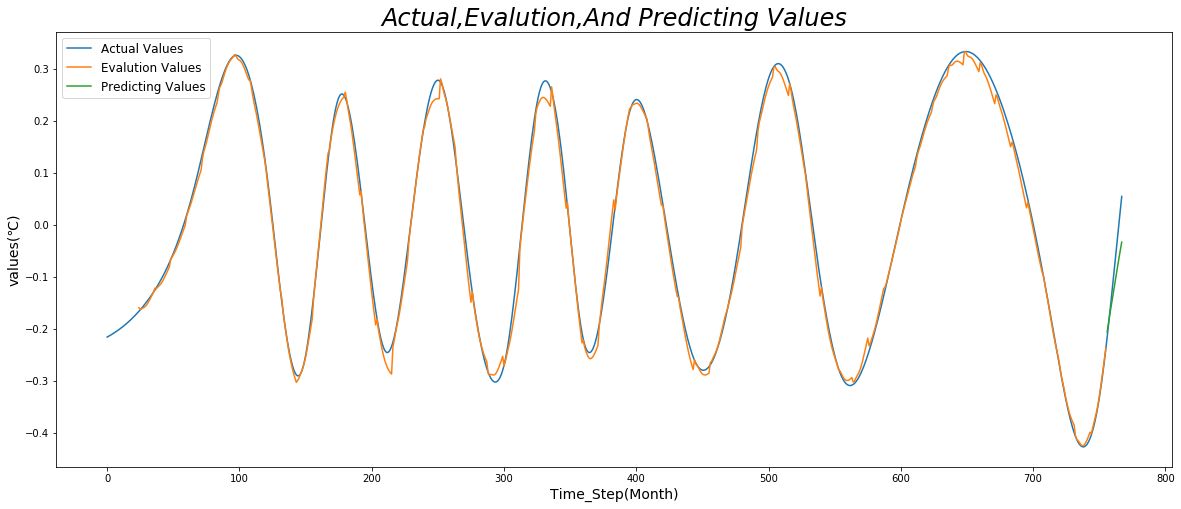

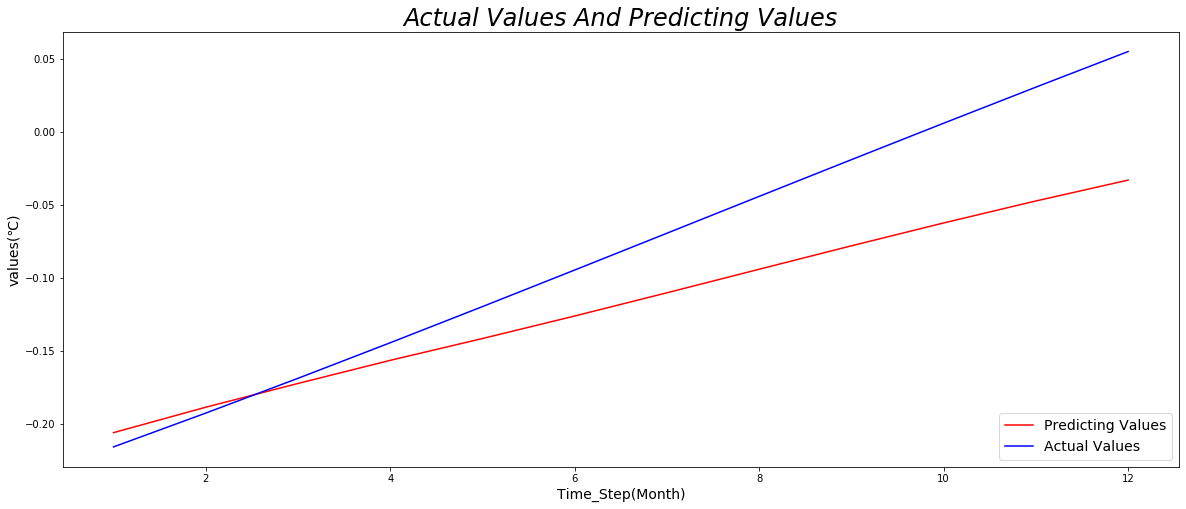

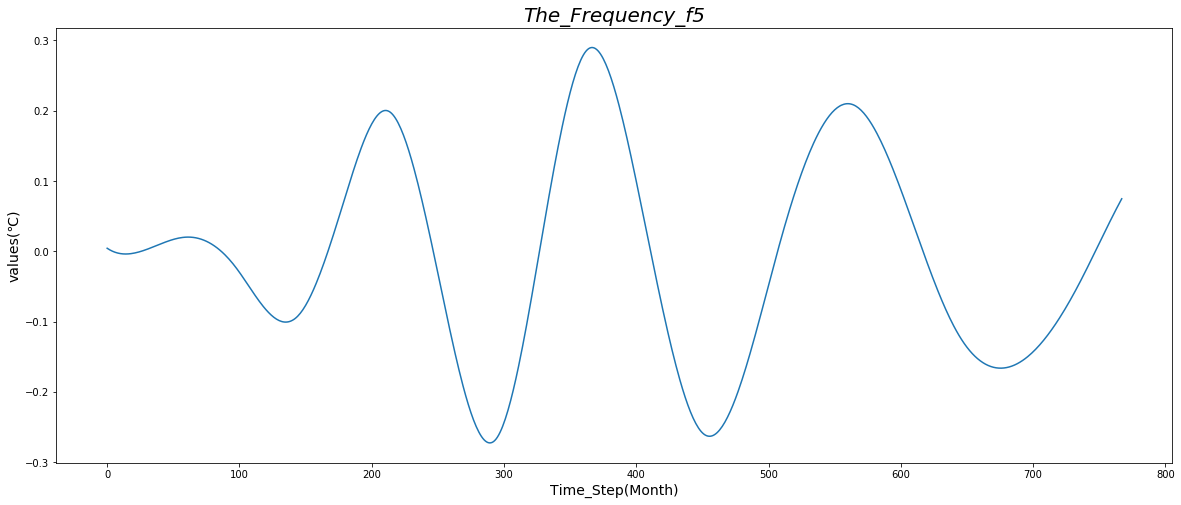

(720, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0129
Epoch 2/200
 - 6s - loss: 0.0055
Epoch 3/200
 - 6s - loss: 0.0020
Epoch 4/200
 - 6s - loss: 0.0013
Epoch 5/200
 - 5s - loss: 9.4180e-04
Epoch 6/200
 - 5s - loss: 7.0938e-04
Epoch 7/200
 - 5s - loss: 5.4340e-04
Epoch 8/200
 - 5s - loss: 5.1278e-04
Epoch 9/200
 - 6s - loss: 4.2076e-04
Epoch 10/200
 - 5s - loss: 3.9569e-04
Epoch 11/200
 - 5s - loss: 3.8522e-04
Epoch 12/200
 - 5s - loss: 3.5038e-04
Epoch 13/200
 - 5s - loss: 3.5299e-04
Epoch 14/200
 - 6s - loss: 3.7472e-04
Epoch 15/200
 - 5s - loss: 4.1386e-04
Epoch 16/200
 - 5s - loss: 3.3714e-04
Epoch 17/200
 - 5s - loss: 4.1702e-04
Epoch 18/200
 - 5s - loss: 3.8781e-04
Epoch 19/200
 - 5s - loss: 5.0662e-04
Epoch 20/200
 - 5s - loss: 4.6131e-04
Epoch 21/200
 - 5s - loss: 3.6586e-04
Epoch 22/200
 - 5s - loss: 3.2638e-04
Epoch 23/200
 - 6s - loss: 3.5081e-04
Epoch 24/200
 - 6s - loss: 4.0256e-04
Epoch 25/200
 - 6s - loss: 3.3268e-04
Epoch 26/200
 - 5s - loss: 2.9586e-04
Epoch 27/200
 - 5s - lo

(61, 12)


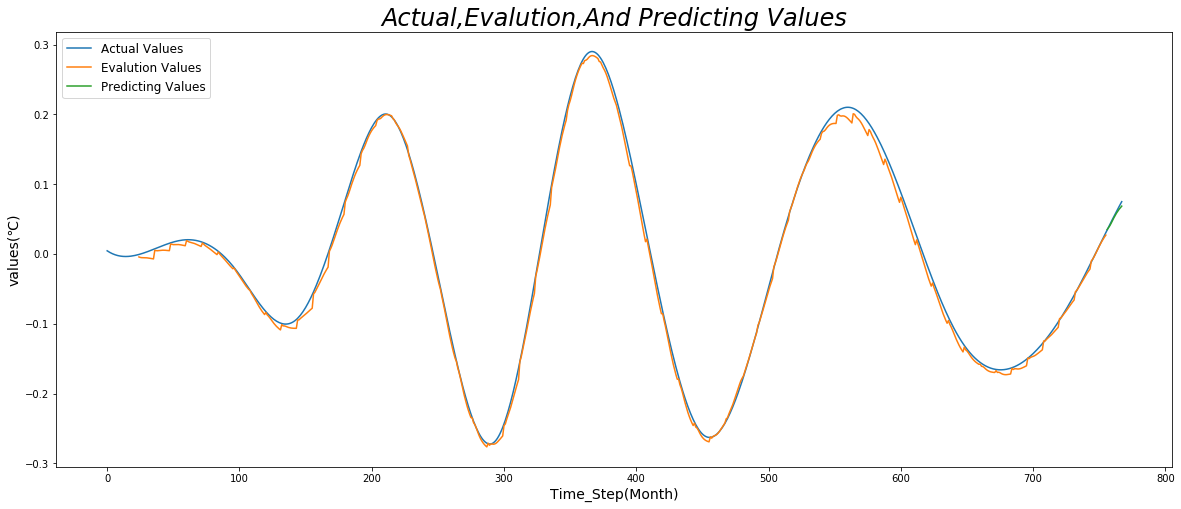

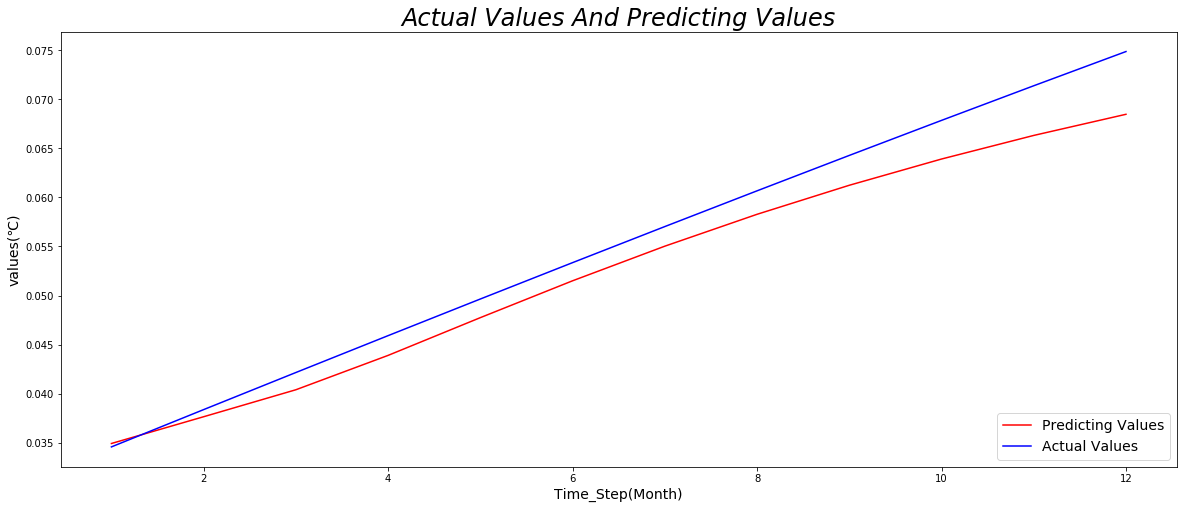

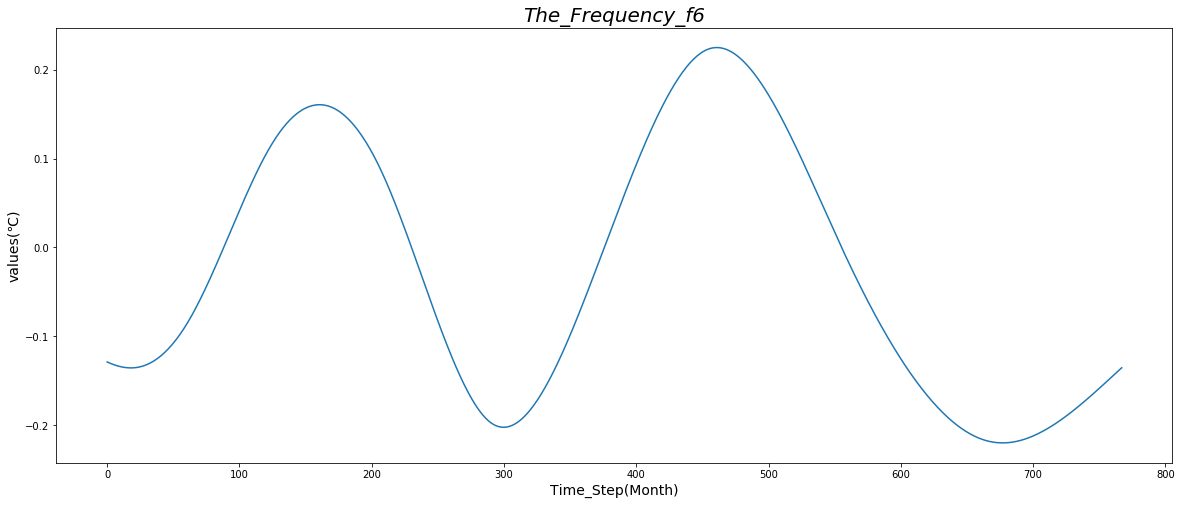

(720, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0102
Epoch 2/200
 - 7s - loss: 0.0037
Epoch 3/200
 - 6s - loss: 0.0018
Epoch 4/200
 - 6s - loss: 8.9987e-04
Epoch 5/200
 - 6s - loss: 7.6671e-04
Epoch 6/200
 - 6s - loss: 4.7367e-04
Epoch 7/200
 - 6s - loss: 3.5484e-04
Epoch 8/200
 - 6s - loss: 3.2265e-04
Epoch 9/200
 - 6s - loss: 3.3375e-04
Epoch 10/200
 - 6s - loss: 2.9830e-04
Epoch 11/200
 - 6s - loss: 3.0375e-04
Epoch 12/200
 - 6s - loss: 3.1017e-04
Epoch 13/200
 - 6s - loss: 2.6518e-04
Epoch 14/200
 - 6s - loss: 2.8176e-04
Epoch 15/200
 - 6s - loss: 2.5064e-04
Epoch 16/200
 - 6s - loss: 2.5115e-04
Epoch 17/200
 - 6s - loss: 2.7116e-04
Epoch 18/200
 - 6s - loss: 3.7947e-04
Epoch 19/200
 - 6s - loss: 4.4718e-04
Epoch 20/200
 - 6s - loss: 3.0555e-04
Epoch 21/200
 - 6s - loss: 2.7711e-04
Epoch 22/200
 - 6s - loss: 3.2614e-04
Epoch 23/200
 - 6s - loss: 3.8816e-04
Epoch 24/200
 - 6s - loss: 3.1602e-04
Epoch 25/200
 - 6s - loss: 2.7343e-04
Epoch 26/200
 - 6s - loss: 2.4627e-04
Epoch 27/200
 - 6s 

(61, 12)


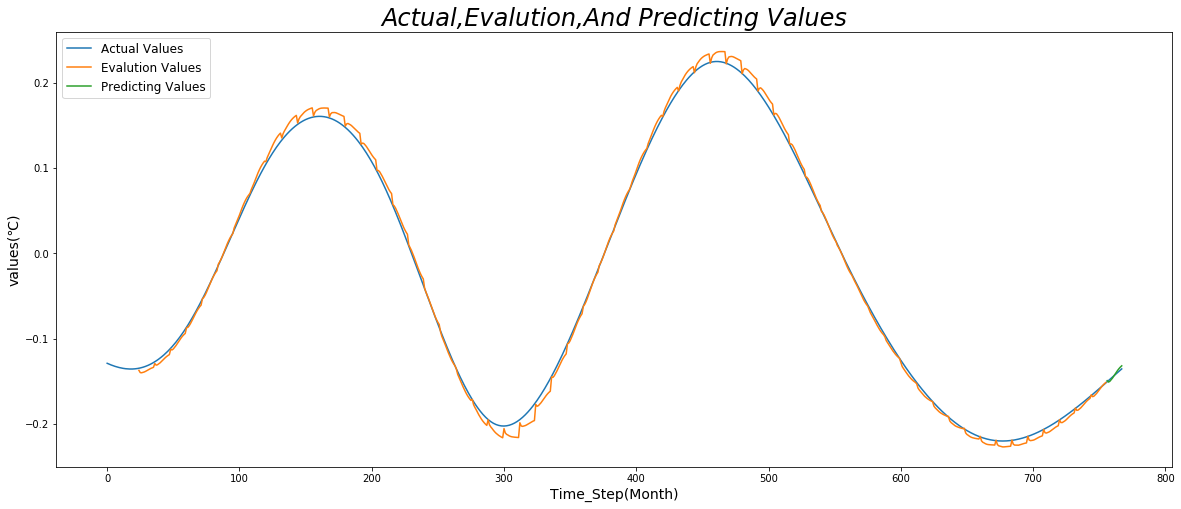

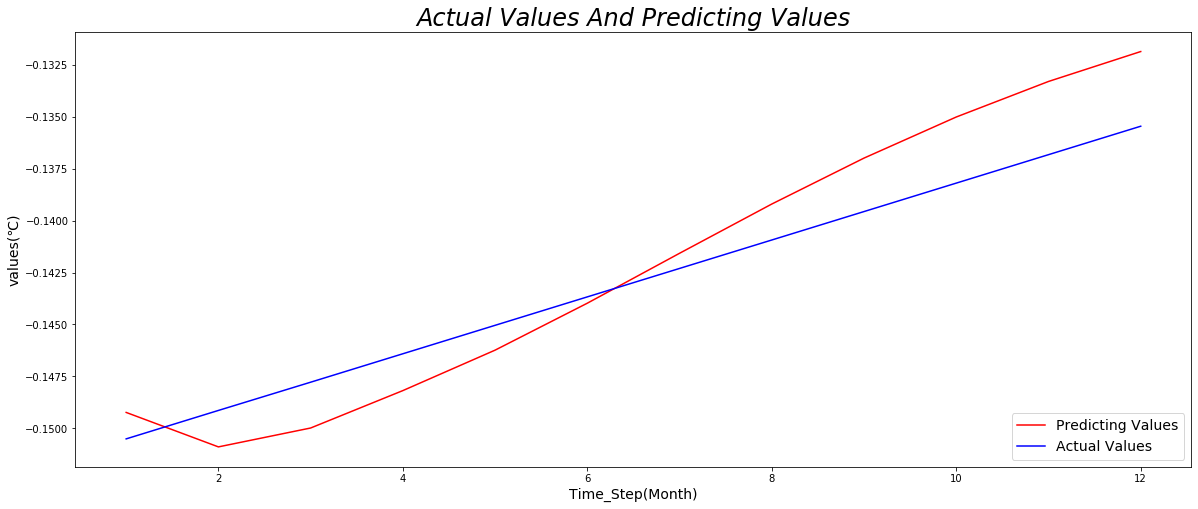

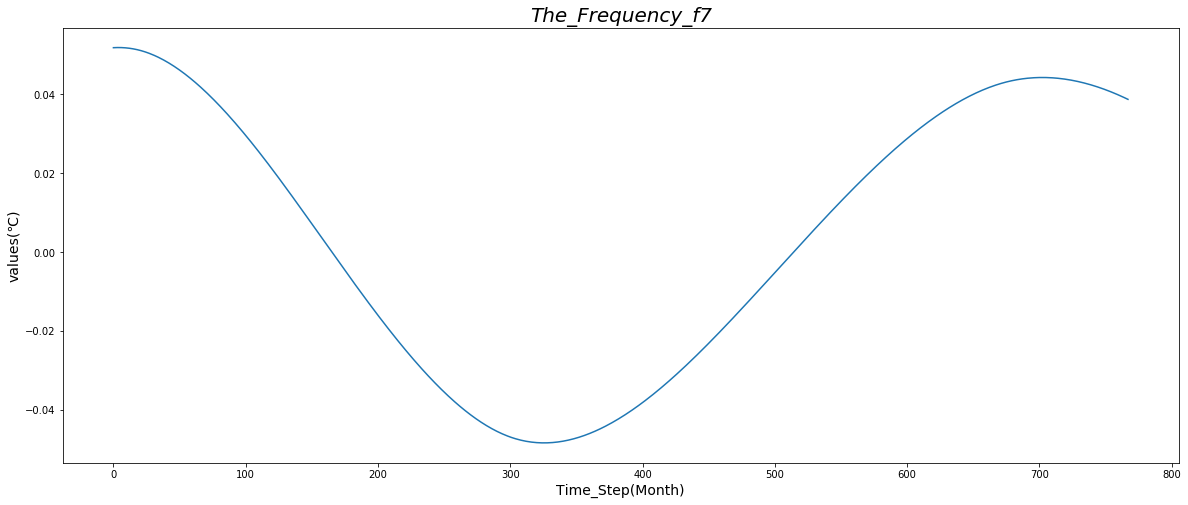

(720, 24, 1)
Epoch 1/200
 - 12s - loss: 7.5857e-04
Epoch 2/200
 - 6s - loss: 2.2814e-04
Epoch 3/200
 - 6s - loss: 1.4248e-04
Epoch 4/200
 - 6s - loss: 9.8118e-05
Epoch 5/200
 - 6s - loss: 8.0105e-05
Epoch 6/200
 - 6s - loss: 7.4368e-05
Epoch 7/200
 - 6s - loss: 5.9482e-05
Epoch 8/200
 - 6s - loss: 5.1598e-05
Epoch 9/200
 - 6s - loss: 4.7869e-05
Epoch 10/200
 - 6s - loss: 4.1760e-05
Epoch 11/200
 - 6s - loss: 4.2761e-05
Epoch 12/200
 - 6s - loss: 4.3703e-05
Epoch 13/200
 - 6s - loss: 4.0965e-05
Epoch 14/200
 - 6s - loss: 3.3689e-05
Epoch 15/200
 - 6s - loss: 3.5151e-05
Epoch 16/200
 - 6s - loss: 3.3441e-05
Epoch 17/200
 - 6s - loss: 3.9100e-05
Epoch 18/200
 - 6s - loss: 2.9372e-05
Epoch 19/200
 - 6s - loss: 2.2720e-05
Epoch 20/200
 - 6s - loss: 2.1182e-05
Epoch 21/200
 - 6s - loss: 1.5118e-05
Epoch 22/200
 - 6s - loss: 1.5025e-05
Epoch 23/200
 - 6s - loss: 1.5916e-05
Epoch 24/200
 - 6s - loss: 2.3503e-05
Epoch 25/200
 - 6s - loss: 1.9303e-05
Epoch 26/200
 - 6s - loss: 1.6095e-05
Epoch 2

(61, 12)


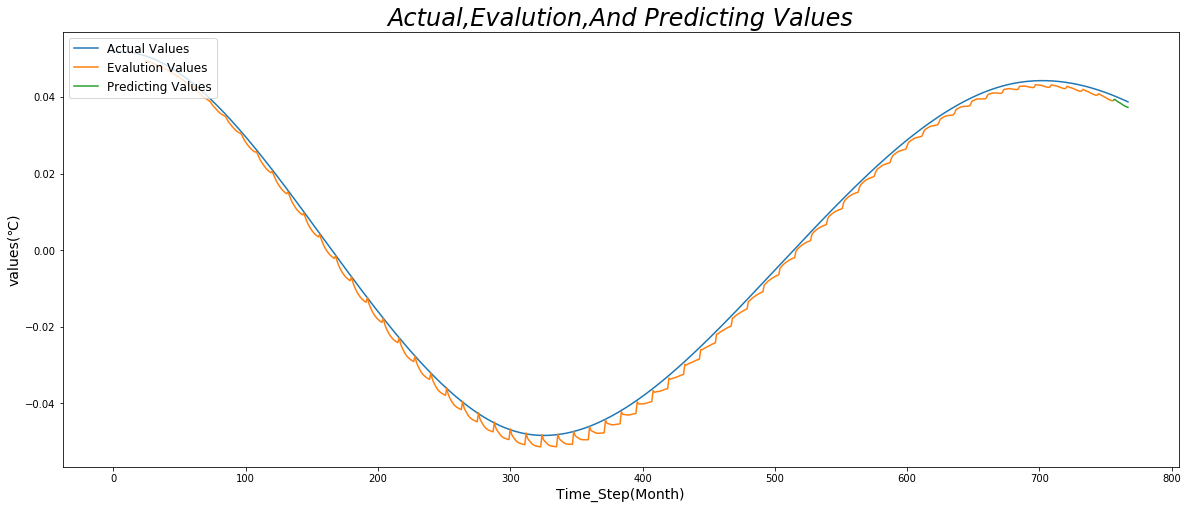

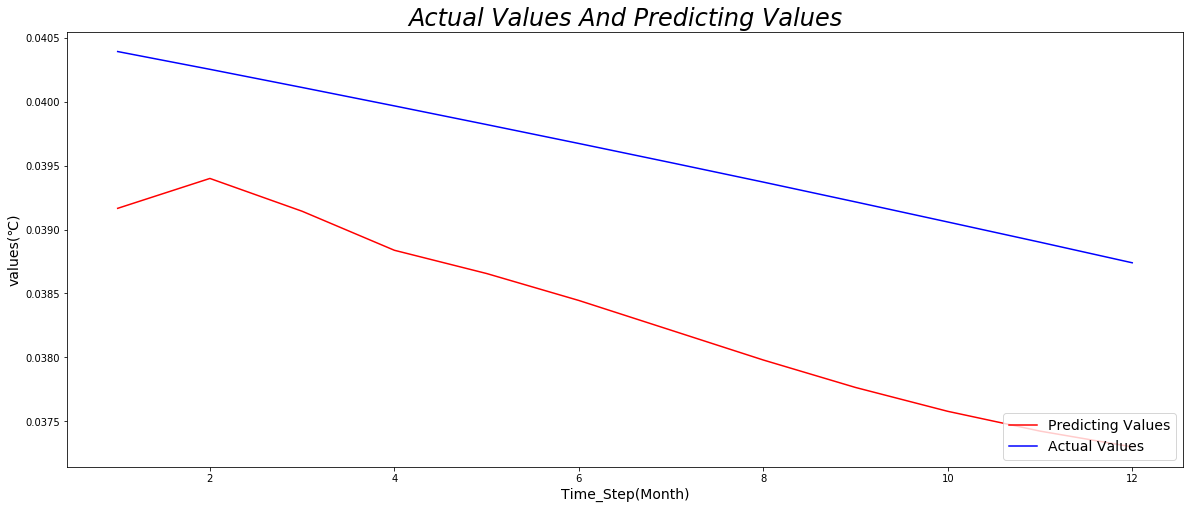

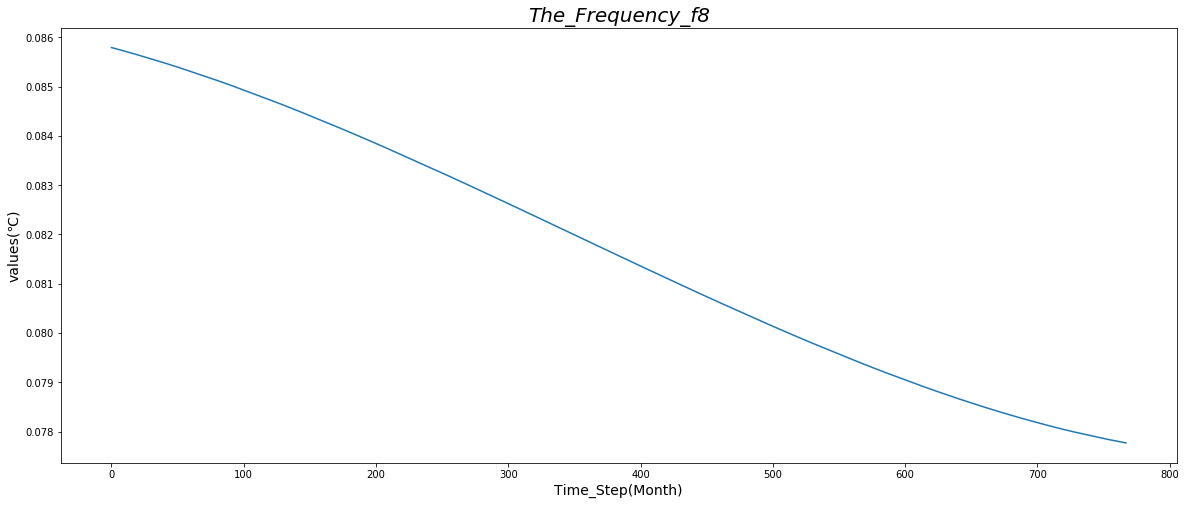

(720, 24, 1)
Epoch 1/200
 - 22s - loss: 5.6517e-04
Epoch 2/200
 - 13s - loss: 1.6186e-05
Epoch 3/200
 - 13s - loss: 7.7591e-06
Epoch 4/200
 - 13s - loss: 7.0461e-06
Epoch 5/200
 - 13s - loss: 6.9426e-06
Epoch 6/200
 - 13s - loss: 6.6348e-06
Epoch 7/200
 - 12s - loss: 6.7106e-06
Epoch 8/200
 - 12s - loss: 6.3929e-06
Epoch 9/200
 - 12s - loss: 6.6930e-06
Epoch 10/200
 - 12s - loss: 6.3779e-06
Epoch 11/200
 - 13s - loss: 6.5327e-06
Epoch 12/200
 - 14s - loss: 6.2227e-06
Epoch 13/200
 - 13s - loss: 6.6353e-06
Epoch 14/200
 - 12s - loss: 7.8295e-06
Epoch 15/200
 - 12s - loss: 7.2802e-06
Epoch 16/200
 - 11s - loss: 6.6549e-06
Epoch 17/200
 - 11s - loss: 7.0984e-06
Epoch 18/200
 - 11s - loss: 6.7591e-06
Epoch 19/200
 - 11s - loss: 6.8786e-06
Epoch 20/200
 - 11s - loss: 6.2058e-06
Epoch 21/200
 - 11s - loss: 6.6387e-06
Epoch 22/200
 - 11s - loss: 6.0720e-06
Epoch 23/200
 - 11s - loss: 6.1064e-06
Epoch 24/200
 - 11s - loss: 6.0747e-06
Epoch 25/200
 - 11s - loss: 6.0889e-06
Epoch 26/200
 - 11s -

(61, 12)


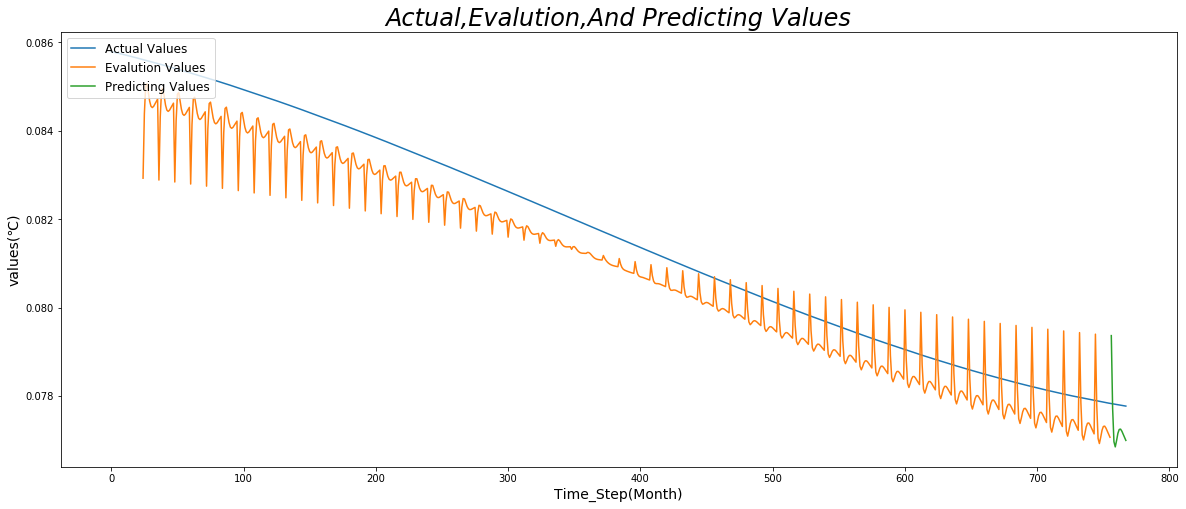

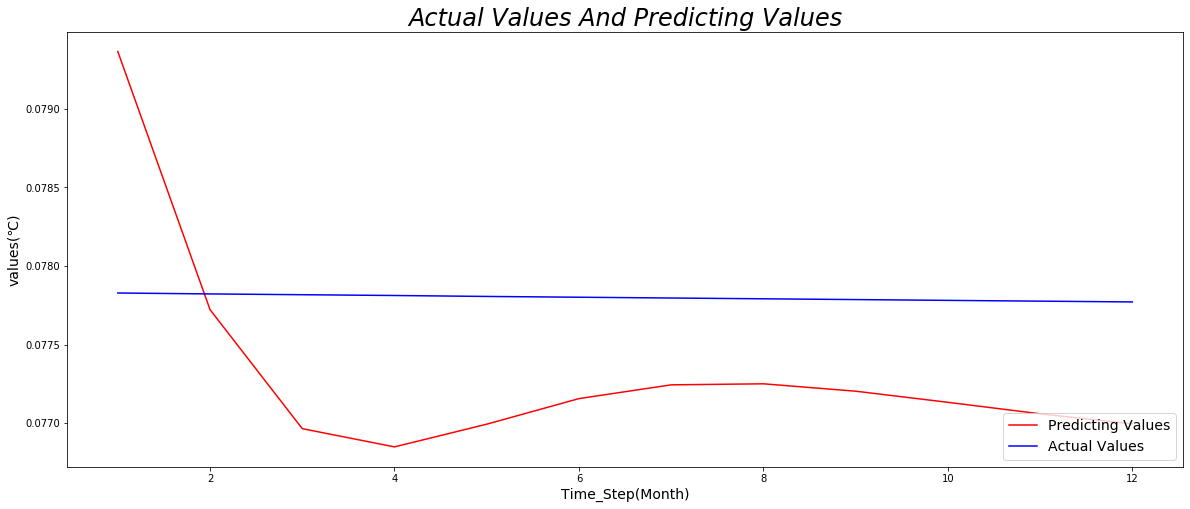

In [9]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-60]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [10]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07936522]
 [0.07772188]
 [0.07696427]
 [0.0768481 ]
 [0.07699274]
 [0.07715554]
 [0.07724313]
 [0.07724977]
 [0.07720273]
 [0.07713199]
 [0.07705886]
 [0.07699474]]
[array([-0.045968 ,  0.025651 ,  0.04502  ,  0.014518 , -0.043308 ,
        0.044599 , -0.025464 , -0.05469  ,  0.0036598,  0.079245 ,
        0.087195 ,  0.0072411]), array([-0.15361 , -0.072965,  0.044407,  0.096376,  0.061819, -0.026199,
       -0.056685, -0.023493,  0.02222 ,  0.044032,  0.021371, -0.02567 ]), array([-0.022442 , -0.049362 , -0.057898 , -0.049598 , -0.028074 ,
       -0.0026341,  0.015288 ,  0.017141 ,  0.0067072, -0.0089625,
       -0.023666 , -0.036315 ]), array([ 0.03549 , -0.018022, -0.075032, -0.13411 , -0.19295 , -0.24823 ,
       -0.29568 , -0.33157 , -0.35515 , -0.3666  , -0.3666  , -0.35602 ]), array([-0.21574  , -0.1926   , -0.1688   , -0.14446  , -0.11972  ,
       -0.094688 , -0.069505 , -0.044291 , -0.019166 ,  0.0057762,
        0.030458 ,  0.054833 ]), array([0.034566, 0.038368, 0.0421

In [11]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.045968   0.025651   0.04502    0.014518  -0.043308   0.044599
 -0.025464  -0.05469    0.0036598  0.079245   0.087195   0.0072411]
[[-0.045968 ]
 [ 0.025651 ]
 [ 0.04502  ]
 [ 0.014518 ]
 [-0.043308 ]
 [ 0.044599 ]
 [-0.025464 ]
 [-0.05469  ]
 [ 0.0036598]
 [ 0.079245 ]
 [ 0.087195 ]
 [ 0.0072411]]
[[-0.05]
 [ 0.03]
 [ 0.05]
 [ 0.01]
 [-0.04]
 [ 0.04]
 [-0.03]
 [-0.05]
 [ 0.  ]
 [ 0.08]
 [ 0.09]
 [ 0.01]]
-----------------------------------
observe value:[-0.15361  -0.072965  0.044407  0.096376  0.061819 -0.026199 -0.056685
 -0.023493  0.02222   0.044032  0.021371 -0.02567 ]
[[-0.199578 ]
 [-0.047314 ]
 [ 0.089427 ]
 [ 0.110894 ]
 [ 0.018511 ]
 [ 0.0184   ]
 [-0.082149 ]
 [-0.078183 ]
 [ 0.0258798]
 [ 0.123277 ]
 [ 0.108566 ]
 [-0.0184289]]
[[-0.2 ]
 [-0.05]
 [ 0.09]
 [ 0.11]
 [ 0.02]
 [ 0.02]
 [-0.08]
 [-0.08]
 [ 0.03]
 [ 0.12]
 [ 0.11]
 [-0.02]]
-----------------------------------
observe value:[-0.022442  -0.049362  -0.057898  -0.049598  -0.028074  -0.0026341
  0.01

In [12]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.03659273 -0.02012323 -0.01157388 -0.00508385  0.01563296  0.03620766
  0.03253895  0.00072952 -0.03424862 -0.03996866 -0.01128609  0.02323601]
[-0.03659273 -0.02012323 -0.01157388 -0.00508385  0.01563296  0.03620766
  0.03253895  0.00072952 -0.03424862 -0.03996866 -0.01128609  0.02323601]
the 1 frequence:
predicted_value:[-0.12904292 -0.1709305  -0.19170742 -0.20409039 -0.2055998  -0.18575338
 -0.13866565 -0.06945588  0.00677127  0.07120782  0.10817289  0.1092938 ]
[-0.16563565 -0.19105373 -0.2032813  -0.20917424 -0.18996684 -0.14954571
 -0.1061267  -0.06872636 -0.02747735  0.03123916  0.0968868   0.13252981]
the 2 frequence:
predicted_value:[ 0.00067265 -0.04683886 -0.07463662 -0.0854033  -0.08465516 -0.07805627
 -0.07058464 -0.06613802 -0.06665806 -0.07162746 -0.07852867 -0.08404472]
[-0.164963   -0.23789259 -0.27791791 -0.29457754 -0.274622   -0.22760198
 -0.17671134 -0.13486438 -0.09413541 -0.0403883   0.018

[[-0.4]
 [-0.3]
 [-0.2]
 [-0.2]
 [-0.3]
 [-0.3]
 [-0.4]
 [-0.4]
 [-0.3]
 [-0.2]
 [-0.2]
 [-0.3]]
[-0.33487738 -0.43785475 -0.5091051  -0.55364516 -0.55642547 -0.52535475
 -0.4828753  -0.44121213 -0.39202372 -0.32123967 -0.23751745 -0.17565878]


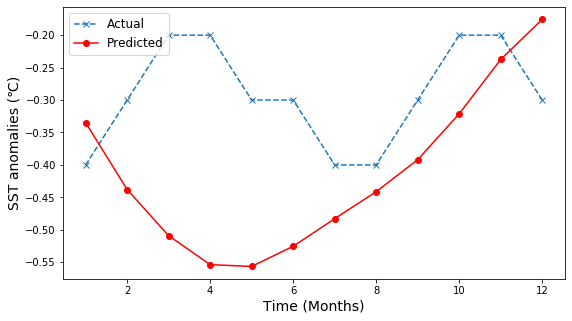

In [13]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
